In [31]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.stats import norm

# Low Discrepancy sequences

Sobol sequence

In [32]:
def Sobol_seq_normal_transformed(d,m, number_paths, scramble_func):
    Sobol_seq = qmc.Sobol(d, scramble = scramble_func) # weil scramble ist noch irgendein Extraschritt und default ist True
    if scramble_func == True:
        sample =  Sobol_seq.random_base2(m)
    elif scramble_func == False:
        sample = Sobol_seq.random_base2(m+1) #aufgrund der Konstruktion berechnen wir 2 mal so viele samples, trennen die erste Zeile ab und nehmen dann die richtige Anzahl
        sample = sample[1:number_paths+1,:]


    #hier nachher wieder ändern
    #sample[0,:] = np.zeros(d)
    #print(sample)

    #uniform random variable to normal distributed random varianle
    return norm.ppf(sample,loc = 0, scale = 1) #scale is standard deviation not variance!!!

In [3]:
d, scramble_func, m = 10, False, 3
Sobol_seq = qmc.Sobol(d, scramble = scramble_func) # weil scramble ist noch irgendein Extraschritt und default ist True

sample =  Sobol_seq.random_base2(m)
sample

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  ,
        0.5  ],
       [0.75 , 0.25 , 0.25 , 0.25 , 0.75 , 0.75 , 0.25 , 0.75 , 0.75 ,
        0.75 ],
       [0.25 , 0.75 , 0.75 , 0.75 , 0.25 , 0.25 , 0.75 , 0.25 , 0.25 ,
        0.25 ],
       [0.375, 0.375, 0.625, 0.875, 0.375, 0.125, 0.375, 0.875, 0.875,
        0.625],
       [0.875, 0.875, 0.125, 0.375, 0.875, 0.625, 0.875, 0.375, 0.375,
        0.125],
       [0.625, 0.125, 0.875, 0.625, 0.625, 0.875, 0.125, 0.125, 0.125,
        0.375],
       [0.125, 0.625, 0.375, 0.125, 0.125, 0.375, 0.625, 0.625, 0.625,
        0.875]])

Halton sequence

In [33]:
def Halton_seq_normal_transformed(d, mc_runs, scramble_func):
    Halton_seq = qmc.Halton(d, scramble=scramble_func)
    if scramble_func == False:
        sample = Halton_seq.random(n=mc_runs+1)
        sample=sample[1:,:]                      #ohne sampling nehmen wir die erste Zeile raus, da dorrt nur Nullen stehen, die man nicht sinnvoll invertieren kann
    elif scramble_func == True:
        sample = Halton_seq.random(n=mc_runs)
    #display(sample)
    #display(norm.ppf(sample, loc = 0, scale = 1))
    return norm.ppf(sample, loc = 0, scale = 1)

In [17]:
Halton_seq = qmc.Halton(4, scramble=False)
sample = Halton_seq.random(n=10)
sample

array([[0.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.33333333, 0.2       , 0.14285714],
       [0.25      , 0.66666667, 0.4       , 0.28571429],
       [0.75      , 0.11111111, 0.6       , 0.42857143],
       [0.125     , 0.44444444, 0.8       , 0.57142857],
       [0.625     , 0.77777778, 0.04      , 0.71428571],
       [0.375     , 0.22222222, 0.24      , 0.85714286],
       [0.875     , 0.55555556, 0.44      , 0.02040816],
       [0.0625    , 0.88888889, 0.64      , 0.16326531],
       [0.5625    , 0.03703704, 0.84      , 0.30612245]])

In [34]:
def get_BB_power2(n):
    k = 0
    while n%2**k == 0:
        k=k+1
    return (k-1)

BB Konstruktion

In [35]:
def get_indices_to_calculate(X):
    to_calculate = np.argwhere(np.isnan(X[0,:]) == True)
    return to_calculate

def get_indices_is_calculated(X):
    is_calculated = np.argwhere(np.isnan(X[0,:]) == False)
    return is_calculated

def create_BB(number_paths, M, sigma, g, delta_t, m, scramble_func, Sobol_not_Halton, QMC):
    h = M                       #h : Differenz der Punkte in Indexpunkten   Sit das h hier das a aus dem paper?
    X = np.empty((number_paths,M+1))       #+1 damit die 0 am Anfang mit dabei ist
    X[:] = np.nan
    X[:,0] = 0

    if QMC == False:
        norm_rv = np.random.randn(number_paths,M)

    elif QMC == True:
        if Sobol_not_Halton == True:
            norm_rv = Sobol_seq_normal_transformed(M, m, number_paths, scramble_func)
        elif Sobol_not_Halton == False:
            norm_rv = Halton_seq_normal_transformed(M, number_paths, scramble_func)
    
    current_pos_rv = 0

    X[:,M] = sigma * np.sqrt(M * delta_t) * norm_rv[:,current_pos_rv] #M-1 damit man letzten Eintrag M trifft
    current_pos_rv += 1

    for i in range(g):
        h = int(h/2)
        pos = h
        for j in range(2**i):
            X[:,pos] = (1/2) * X[:,pos - h] + (1/2) * X[:,pos + h] + sigma * np.sqrt((1/2) * h * delta_t) * norm_rv[:, current_pos_rv]
            #print(pos)
            pos = pos + 2*h
            current_pos_rv +=1

    #jetzt die restlichen Werte ausfüllen
    #wir betrachten nur die erste Zeile, weil in den weiteren Pfaden an den gleichen Stellen die Werte fehlen

    i = np.where(np.isnan(X[0,:]) == False)[0][0] #Startwert ist erster Eintrag, der nicht nan ist
    while np.isnan(X).any():
        to_calculate = get_indices_to_calculate(X)
        j = 0
        while to_calculate[j] <= i:
            j +=1

        i = to_calculate[j][0]


        #nun suchen wir den k Index, also den oberen Wert für die Berechnung
        o = 0
        is_calculated = get_indices_is_calculated(X)
        while is_calculated[o] <= i:    #Achtung neues i, nicht das von unten!
            o+=1
        k = is_calculated[o][0]

        j = is_calculated[o-1][0]

        X[:,i] = ((k-i)/(k-j)) * X[:,j] + ((i-j)/(k-j)) * X[:,k] + sigma * np.sqrt(((k-i)/(k-j)) * delta_t) * norm_rv[:,current_pos_rv]
        current_pos_rv += 1
    return X

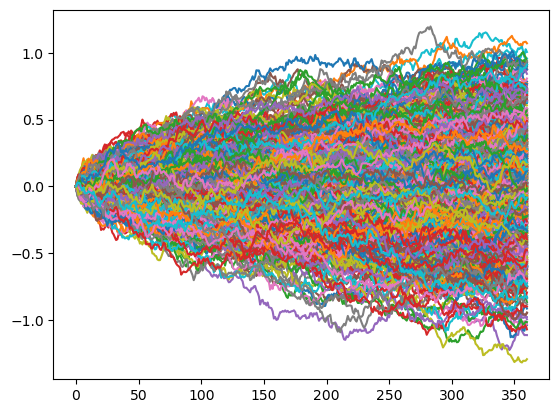

In [71]:
time = np.linspace(0,M,M+1)
X = create_BB(number_paths, M, sigma, g, delta_t)
plt.plot(time, X.T)
plt.show()

Standard Brownian Motion berechnen

In [36]:
def create_standard_bm(sigma, number_paths, M, delta_t, m, scramble_func, Sobol_not_Halton, QMC):
    w = np.empty((number_paths,M))

    if QMC == False:
        for m in range(number_paths):
            #create lower trinangular matrix with ones
            lower_tri_matr = np.tril(np.ones([M,M]))
            A =  math.sqrt(delta_t)*lower_tri_matr #! hier sigma multipiziert, ist das so richtig?
            #create Brownian motion
            w[m,:] = sigma * A.dot(np.random.randn(M))

    elif QMC == True:
        if Sobol_not_Halton == True:
            Sobol_sequence = Sobol_seq_normal_transformed(M, m, number_paths, scramble_func)
            for l in range(number_paths):
                #create lower trinangular matrix with ones
                lower_tri_matr = np.tril(np.ones([M,M]))
                A = sigma * math.sqrt(delta_t)*lower_tri_matr #! hier sigma multipiziert, ist das so richtig?
                #create Brownian motion
                w[l,:] = A.dot(Sobol_sequence[l,:])
        elif Sobol_not_Halton == False: 
            Halton_sequence = Halton_seq_normal_transformed(M, number_paths, scramble_func)
            for l in range(number_paths):
                #create lower trinangular matrix with ones
                lower_tri_matr = np.tril(np.ones([M,M]))
                A = sigma * math.sqrt(delta_t)*lower_tri_matr #! hier sigma multipiziert, ist das so richtig?
                #create Brownian motion
                w[l,:] = A.dot(Halton_sequence[l,:])

        
    w = np.concatenate((np.reshape(np.zeros(number_paths),(number_paths,1)), w),axis=1)
    return w

Berechnung von i_K, w_k, u_k, c_k, r_k, m_k

In [37]:
def create_i_k(BB, number_paths, M, sigma, g, delta_t, m, scramble_func, Sobol_not_Halton, QMC, i_0, K_0):
    if BB == True:
        X = create_BB(number_paths, M, sigma, g, delta_t, m, scramble_func, Sobol_not_Halton, QMC)
    elif BB == False:
        X = create_standard_bm(sigma, number_paths, M, delta_t, m, scramble_func, Sobol_not_Halton, QMC)
    display(X)    
    #create differences of the Wiener process
    delta_X = np.diff(X, axis = 1)

    i_k = np.empty((number_paths,M+1))     #+1 weil i_0 mit drin ist
    i_k[:,0] = i_0
    for n in range(number_paths):
        for j in range(M):
            j = j+1
            i_k[n,j] = i_k[n,j-1]*K_0*math.exp(delta_X[n,j-1])
    i_k = i_k[:,1:]   #i_0 wird abgeschnitten
    #display(i_k)
    return i_k


def create_w_k(i_k, K1, K2, K3, K4, number_paths, M):
    w_k = np.empty((number_paths,M))
    w_k = K1+K2*np.arctan(K3 * i_k + K4)
    return w_k


In [38]:
def create_u_k(number_paths, M, i_k):
    u_k = np.empty((number_paths,M))
    for k in range(M):
        u_k[:,k] = np.prod(1/(i_k[:,0:k+1] + 1), axis = 1)     #hier k+1 weil man bei 0 anfängt
    return u_k

def create_c_k(number_paths, M, i_0):
    c_k = np.ones((number_paths,M))
    for k in range(M):                 
        for j in range(M - (k+1)):
            j = j + 1                   #damit man nicht bei 0 anfängt, erster Summand ist schon 1
            c_k[:,k] = c_k[:,k] + (1 + i_0)**(-j)
    return c_k

def create_r_k(number_paths, M, w_k):
    r_k = np.empty((number_paths, M))
    for k in range(M):
        r_k[:,k] = np.prod(1-w_k[:,0:k] , axis = 1)
    return r_k

def create_m_k(w_k, c_k, r_k, number_paths, M):
    m_k = np.empty((number_paths, M))
    for k in range(M):
        m_k[:,k] = c*r_k[:,k]*((1-w_k[:,k]) + w_k[:,k]*c_k[:,k])
    return m_k



# Monte Carlo Simulation

Monte Carlo Simulation mit Standard BM bzw. random walk und Brownian Bridges

## Set parameters

In [40]:
m = 12
number_paths = 2**m #für Sobol sequence
sigma = np.sqrt(0.0004)
M = 360         #Anzahl der simulierten Monate
g = get_BB_power2(M)                   #numer of simulated points excluding the first one
delta_t = 1 #muss glaube ich 1 sein, weil sonst stimmt die Varianz nicht 


K_0 = math.exp(-(sigma**2)/2)
K1 = 0.01
K2 = -0.005
K3 = 10
K4 = 0.5

c = 1 #monthly payment (beliebig?)

i_0 = 0.007

BB = False
QMC = True
Sobol_not_Halton = False
scramble_func = False


In [28]:
#Achtung i_0 fehlt in i_k
i_k = create_i_k(BB, number_paths, M, sigma, g, delta_t, m, scramble_func, Sobol_not_Halton, QMC, i_0, K_0)
print(i_k.shape)
w_k = create_w_k(i_k, K1, K2, K3, K4, number_paths, M)
print(w_k.shape)
u_k = create_u_k(number_paths, M, i_k)
print(u_k.shape)
c_k = create_c_k(number_paths, M, i_0)
print(c_k.shape)
r_k = create_r_k(number_paths, M, w_k)
print(r_k.shape)
m_k = create_m_k(w_k, c_k, r_k, number_paths, M)
print(m_k.shape)

#i_k_expectation = np.average(i_k[:,5])
#print(i_k_expectation)




expectation = np.sum(np.sum(u_k * m_k,axis=1))/number_paths
print(expectation)

array([[ 0.00000000e+00,  0.00000000e+00, -8.61454599e-03, ...,
        -2.12748313e+01, -2.13417000e+01, -2.14085826e+01],
       [ 0.00000000e+00, -1.34897950e-02, -4.87524902e-03, ...,
        -1.96838463e+01, -1.97467672e+01, -1.98097026e+01],
       [ 0.00000000e+00,  1.34897950e-02, -1.09230120e-02, ...,
        -1.87018168e+01, -1.87623263e+01, -1.88228508e+01],
       ...,
       [ 0.00000000e+00, -3.05984898e-06,  1.32947032e-02, ...,
         2.58736438e-01,  2.74033788e-01,  2.88226895e-01],
       [ 0.00000000e+00,  7.68386137e-02,  5.93824213e-02, ...,
         2.03754765e-01,  2.19079919e-01,  2.33299653e-01],
       [ 0.00000000e+00, -8.01754519e-02, -7.89355435e-02, ...,
         2.21546842e-01,  2.36899830e-01,  2.51146217e-01]])

(16384, 360)
(16384, 360)
(16384, 360)
(16384, 360)
(16384, 360)
(16384, 360)
132.32881681662536


<function matplotlib.pyplot.show(close=None, block=None)>

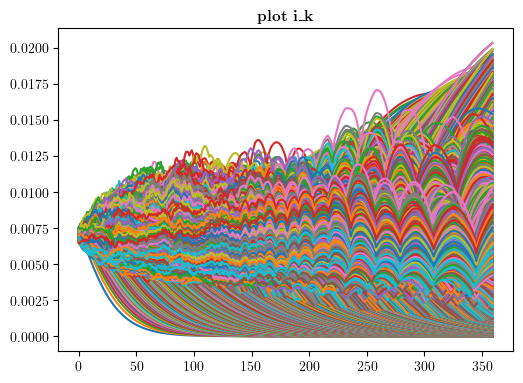

In [46]:
fig = plt.figure(figsize = (5.87086,4.1918))


plt.rc('text', usetex=True)
plt.rc('font', family = 'Computer Modern')

plt.plot(i_k.T)

plt.title(r'\textbf{plot i_k}', fontsize = 11)
fig.savefig('test.png', dpi = 500)
plt.show

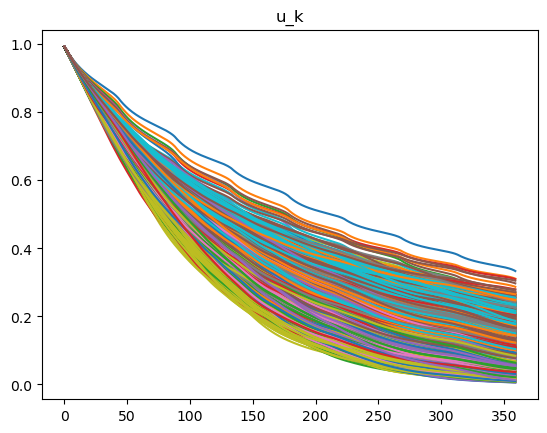

<function matplotlib.pyplot.show(close=None, block=None)>

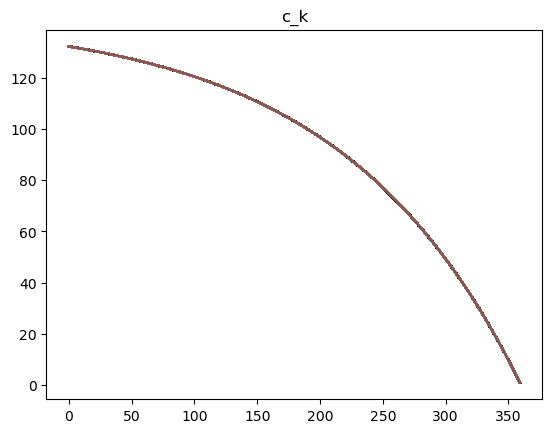

In [13]:
plt.plot(u_k.T)
plt.title("u_k")
plt.show()


plt.plot(c_k.T)
plt.title("c_k")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

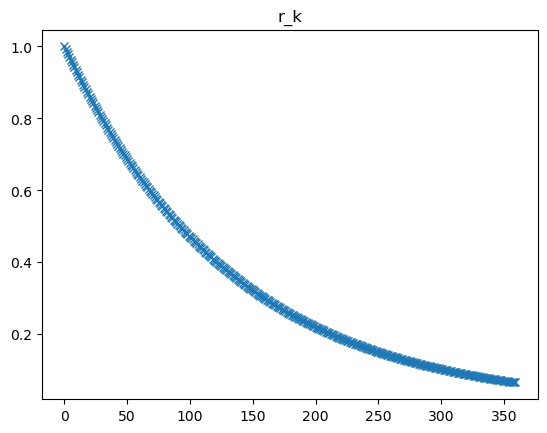

In [14]:
#plt.plot(m_k.T)
#plt.title("m_k")
#plt.show

plt.plot(r_k[5,:].T,'x')
plt.title("r_k")
plt.show